<!--Header-->
<div style="background-color: #fff; color: black">
    <div style="padding-bottom: 20px; display: flex; justify-content: space-between; align-items: flex-start;">
        <div style="width: 60%;">
            <h1 style="margin: 16px">TFG - Inteligencia Artificial</h1>
            <p style="margin: 16px; padding-bottom: 0">Junio de 2025</p>
        </div>
        <div style="width: 40%; text-align: right">
            <img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" alt="Logo UOC">
        </div>
    </div>
    <h2 style="text-align: justify; padding: 0 16px">Aplicación de técnicas de IA fiable en la predicción del índice de calidad de vida en personas con tratamiento oncológico mediante aprendizaje automático.</h2>
    <div style="background-color: #000; width: 100%; height: 2px; margin: 24px 0"></div>
    <div style="padding: 20px">
        <h4 style="margin: 0 0; padding: 0 0">Pablo Pimàs Verge</h4>
        <h5 style="margin: 0 0; padding: 0 0">Grado en Ingeniería Informática</h5>
        <h5 style="margin: 0 0 4px; padding: 0 0">Inteligencia Artificial</h5>
        <h4 style="margin: 8px 0 4px; padding: 0 0">Dra. María Moreno de Castro</h4>
        <h4 style="margin: 0 0; padding: 0 0">Dr. Friman Sanchéz</h4>
    </div>
</div>

<!--/Header-->

# Fase 2
#### Segunda Parte
##### - Entrenamiento de modelos
##### - Aplicación del modelo óptimo

# Modelado

El problema se plantea como una clasificación multiclase del índice de calidad de vida (QoL) en personas con tratamiento oncológico. En la primera parte se ha realizado el análisis exploratorio de datos y la preparación [1]. Se han identificado dos tipos de predictores: las variables que informan aspectos de funcionamiento e inciden positivamente en el QoL; y las variables que informan síntomas, producidos por la enfermedad o el tratamiento, e inciden negativamente en el QoL. Por razones prácticas, nombraremos a estos dos tipos variables directas y variables inversas respectivamente. Con respecto a la preparación, se ha reducido la variable calidad de vida QoL a 3 clases para mejorar la clasificación y dotarla de sentido semántico, estas clases son: 0 (baja), 1 (media) y 2 (alta). Además, del conjunto inicial con 1727 observaciones, se han eliminado 249 filas con valores nulos en todas las columnas y 4 filas con valores nulos en las variables del dominio C23. Por último, también se han eliminado las variables Upset by hair loss y Sexual enjoyment por contener más de un 60% de valores nulos. Por lo tanto, el conjunto resultante contiene 1474 observaciones compuestas por 20 predictores y la variable objetivo.

Este cuaderno corresponde a la segunda parte de la fase 2 del plan de trabajo del TFG. Se aborda el entrenamiento y la aplicación de los modelos previstos al conjunto de datos resultante de la preparación. Estas tareas corresponden a la fase de modelado en el marco de CRISP-DM.


### Objetivos

En el presente cuaderno se realizarán las siguientes acciones: 

- Separar los datos de df_C30_C23 en los conjuntos de: entrenamiento, prueba y calibración
- Entrenar y aplicar los siguientes modelos:

    - Decision Tree
    - Random Forest
    - XGBoost 

### Índice

1. Entrenamiento y clasificación
2. Conclusiones

### Importaciones


In [25]:
# Importaciones de librerías básicas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Importaciones de Scikit-learn para preparación de datos, evaluación de modelos y optimización de parámetros
from sklearn.model_selection import train_test_split, GridSearchCV

# Importaciones de Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Funciones auxiliares
import aux_functions as afn

In [26]:
# Configuraciones
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
plt.rc('font', size=10)
plt.rcParams["legend.frameon"] = False
sns.set_theme(
    style="white",
    palette="viridis",
    rc={
        "axes.spines.left": False,
        "axes.spines.bottom": False,
        "axes.spines.right": False,
        "axes.spines.top": False
    }
)
sns.set_style("white", {"axes.grid": False})

### Carga de los datos

In [27]:
# Carga de los datos en un dataframe de Pandas a partir del conjunto generado en la fase previa en formato csv
file_path = "./data/QLQ_C30_C23_3.csv"
df = pd.read_csv(file_path)
# Filas duplicadas
print('Total de observaciones sin duplicados: ', df.duplicated().count())

Total de observaciones sin duplicados:  1474


In [28]:
# Comprobamos que el conjunto importado contiene las 1474 observaciones sin valores faltantes y las 21 variables de tipo decimal (float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Edad                           1474 non-null   float64
 1   Physical functioning           1474 non-null   float64
 2   Role functioning               1474 non-null   float64
 3   Emotional functioning          1474 non-null   float64
 4   Cognitive functioning          1474 non-null   float64
 5   Social functioning             1474 non-null   float64
 6   Fatigue                        1474 non-null   float64
 7   Nausea and vomiting            1474 non-null   float64
 8   Pain                           1474 non-null   float64
 9   Dyspnea                        1474 non-null   float64
 10  Insomnia                       1474 non-null   float64
 11  Appetite loss                  1474 non-null   float64
 12  Constipation                   1474 non-null   f

## 1. Creación de los conjuntos de entrenamiento, prueba y calibración

Con el fin de cuantificar la incertidumbre del modelo en la próxima etapa, es necesario reservar un subconjunto de los datos, que se utilizarán para realizar la calibración. Para ello, separamos un 20% del conjunto inicial, ya que el modelo no debe conocerlos durante el entrenamiento.

Para la división de los conjuntos de entrenamiento, prueba y calibración aplicaremos una proporción de 70-20-10 con estratificación para asegurar que las clases de la variable objetivo se distribuyen uniformemente en todos los conjuntos. 


In [29]:
# Extracción de las variables independientes en un dataframe y de la variable dependiente en una serie
X = df.drop('QoL', axis=1)
y = df['QoL']
# Separación del conjunto de calibración
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=73)
# Division de los datos de entrenamiento y test
X_test, X_cal, y_test, y_cal = train_test_split(X_rest, y_rest, test_size=0.3, stratify=y_rest, random_state=73)

Una vez dispuestos todos los conjuntos necesarios, mediante la función auxiliar viz_split_distributions realizaremos una comprobación de la distribución de las 3 clases en cada uno de ellos. 

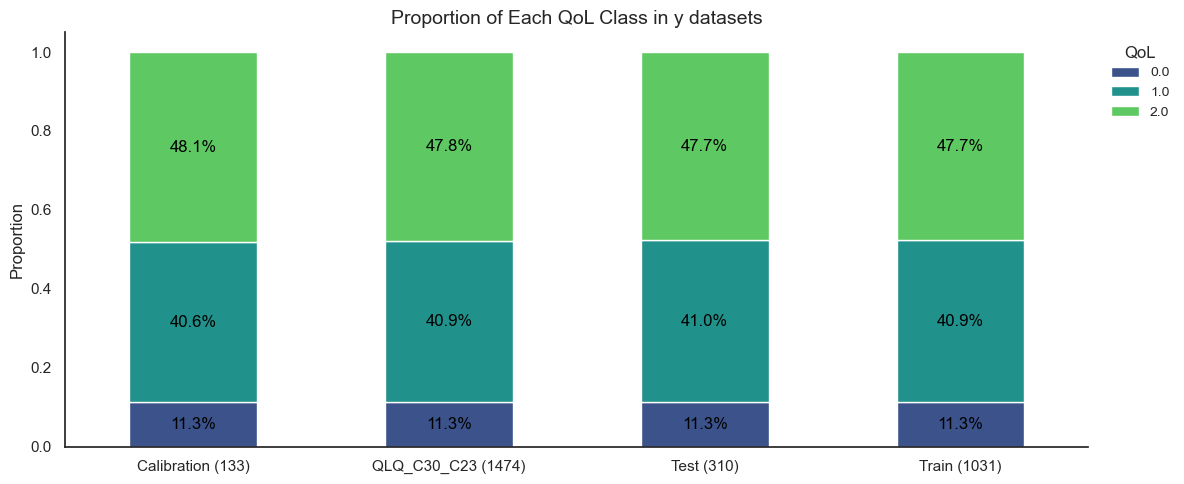

In [30]:
afn.viz_split_distributions([df['QoL'], y_train, y_test, y_cal], ['QLQ_C30_C23', 'Train', 'Test', 'Calibration'])

Podemos ver que la distribución de la variable objetivo tiene una variación inferior al 1% para cada clase en todos los conjuntos generados. Además, las 1474 observaciones del conjunto original se han separado en: 1031 para entrenamiento, 310 para pruebas y 133 para calibración.

In [31]:
# Guardamos los nombres de las clases de la variable objetivo para utilizarlas en las funciones auxiliares
labels = ['Baja', 'Media', 'Alta']

## 2. Entrenamiento

Para la clasificación se entrenarán los siguientes modelos:

- Decision Tree 
- Random Forest
- XGBoost
- CatBoost
- LightGBM

### 2.1 Decision Tree

In [32]:
# Instanciamos el modelo 
dt_model =  DecisionTreeClassifier(random_state=73)
# Establecemos un diccionario con los valores de los parámetros que tomará el modelo en el entrenamiento
dt_parameters = {
    # Criterios para medir la ganancia de información (calidad de la división)
    'criterion': ['gini', 'entropy'],
    # Estrategias de división
    'splitter': ['best', 'random'],
    # Máxima profundidades del árbol (None permite la profundidad máxima posible)
    'max_depth': [6, 8, 10],
    # Mínimo de casos para dividir un nodo
    'min_samples_split': [3, 4, 5],
    # Mínimo de casos en las hojas
    'min_samples_leaf': [13, 14, 15],
    # Factor de poda
    'ccp_alpha': [0.009, 0.01, 0.011],
    # Balanceo de clases
    'class_weight': [None, {0:3, 1:1, 2:1}]
}
# Creamos la grilla de búsqueda de parámetros
dt_grid = GridSearchCV(
    estimator=dt_model, 
    param_grid=dt_parameters, 
    verbose=1,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
# Entrenamos los modelos generados por la grilla
dt_grid.fit(X_train, y_train)
# Visualización de los resultados
print('Media de F1 score:: %.3f' % dt_grid.best_score_)
print('Desviación estándar: ', dt_grid.cv_results_['std_test_score'][dt_grid.best_index_].round(3))
print('Parámetros que producen el clasificador óptimo: ')
print('Criterio: ', dt_grid.best_params_['criterion'])
print('Estrategia: ', dt_grid.best_params_['splitter'])
print('Profundidad máxima: ', dt_grid.best_params_['max_depth'])
print('Mínimo de muestras por división: ', dt_grid.best_params_['min_samples_split'])
print('Mínimo de muestras por hoja: ', dt_grid.best_params_['min_samples_leaf'])
print('Factor de poda: ', dt_grid.best_params_['ccp_alpha'])
print('Balanceo de clases: ', dt_grid.best_params_['class_weight'])
print('Cantidad de nodos: ', dt_grid.best_estimator_.tree_.node_count)
print('Cantidad de hojas: ', dt_grid.best_estimator_.tree_.n_leaves)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Media de F1 score:: 0.603
Desviación estándar:  0.031
Parámetros que producen el clasificador óptimo: 
Criterio:  gini
Estrategia:  best
Profundidad máxima:  6
Mínimo de muestras por división:  3
Mínimo de muestras por hoja:  13
Factor de poda:  0.011
Balanceo de clases:  None
Cantidad de nodos:  11
Cantidad de hojas:  6


Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.66      0.39      0.49       117
         1.0       0.60      0.81      0.69       422
         2.0       0.81      0.65      0.72       492

    accuracy                           0.68      1031
   macro avg       0.69      0.62      0.63      1031
weighted avg       0.71      0.68      0.68      1031

Reporte sobre el conjunto de prueba:  PRUEBA
              precision    recall  f1-score   support

         0.0       0.47      0.26      0.33        35
         1.0       0.57      0.76      0.65       127
         2.0       0.77      0.64      0.70       148

    accuracy                           0.65       310
   macro avg       0.61      0.55      0.56       310
weighted avg       0.66      0.65      0.64       310



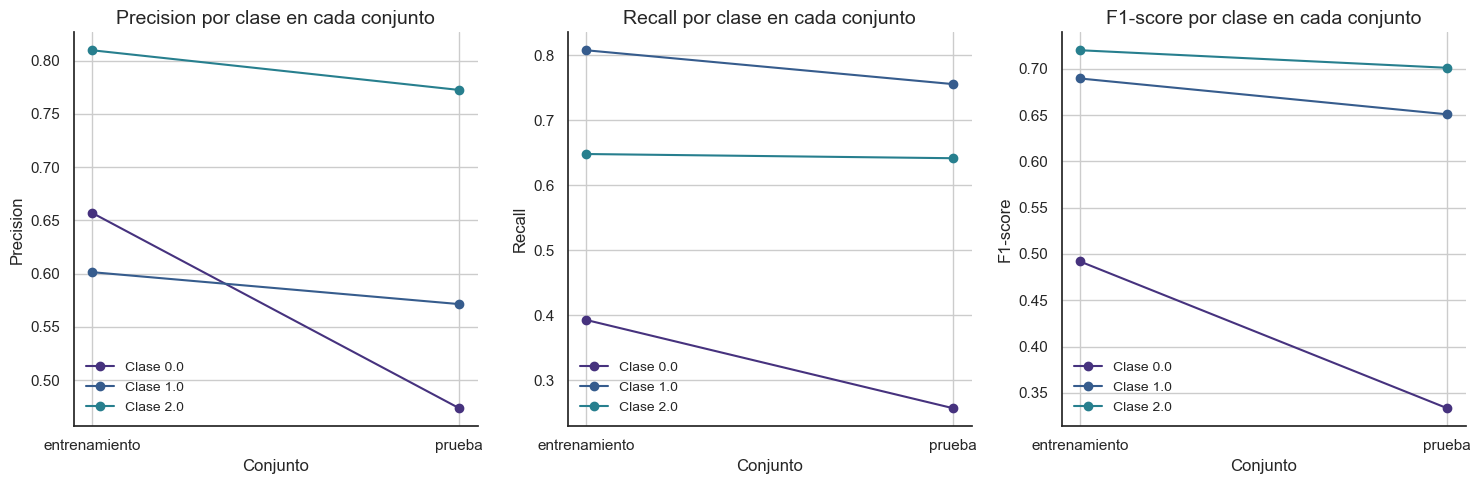

In [33]:
# Entrenamos el modelo con los mejores hiperparámetros
dt_model = dt_grid.best_estimator_
dt_model.fit(X_train, y_train)
y_pred_train_dt, y_pred_test_dt = afn.viz_classification_reports(dt_model, X_train, y_train, X_test, y_test, 'prueba')


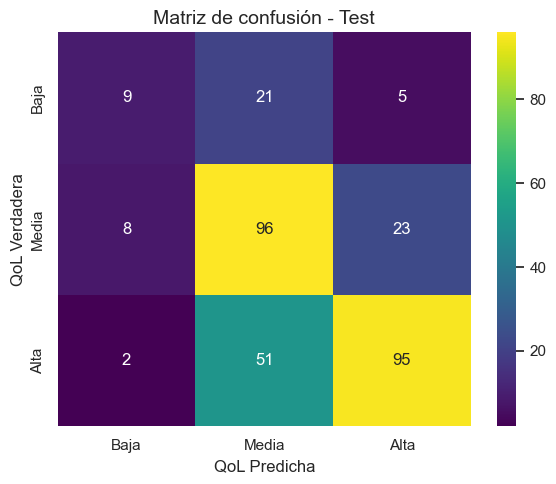

In [34]:
afn.viz_confusion_matrix_test(labels, y_test, y_pred_test_dt)

### 2.2 Random Forest

In [35]:
rf_model = RandomForestClassifier(
    random_state = 73,
    n_jobs=-1
)

rf_parameters = {
    'criterion': ['gini', 'entropy'],
    # Número de árboles en cada modelo
    'n_estimators': [90, 100, 110],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [3, 4, 5],
    'ccp_alpha': [0.009, 0.01, 0.011],
    'class_weight': [None, {0:3, 1:1, 2:1}]
}

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_parameters,
    scoring='f1_macro',
    verbose=True,
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print('Media de F1 score: %.3f' % rf_grid.best_score_)
print('Desviación estándar: ', rf_grid.cv_results_['std_test_score'][rf_grid.best_index_].round(3))
print('Parámetros que producen el clasificador óptimo: ')
print('Criterio: ', rf_grid.best_params_['criterion'])
print('Profundidad máxima: ', rf_grid.best_params_['max_depth'])
print('Mínimo de muestras por división: ', rf_grid.best_params_['min_samples_split'])
print('Mínimo de muestras por hoja: ', rf_grid.best_params_['min_samples_leaf'])
print('Factor de poda: ', rf_grid.best_params_['ccp_alpha'])
print('Balanceo de clases: ', rf_grid.best_params_['class_weight'])
print('Cantidad de árboles: ', rf_grid.best_params_['n_estimators'])
print('Cantidad de nodos del primer árbol: ', rf_grid.best_estimator_.estimators_[0].tree_.node_count)
print('Cantidad de hojas del primer árbol: ', rf_grid.best_estimator_.estimators_[0].tree_.n_leaves)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Media de F1 score: 0.654
Desviación estándar:  0.032
Parámetros que producen el clasificador óptimo: 
Criterio:  entropy
Profundidad máxima:  5
Mínimo de muestras por división:  3
Mínimo de muestras por hoja:  4
Factor de poda:  0.01
Balanceo de clases:  {0: 3, 1: 1, 2: 1}
Cantidad de árboles:  110
Cantidad de nodos del primer árbol:  33
Cantidad de hojas del primer árbol:  17


Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.65      0.71      0.68       117
         1.0       0.75      0.64      0.69       422
         2.0       0.77      0.85      0.81       492

    accuracy                           0.75      1031
   macro avg       0.72      0.73      0.72      1031
weighted avg       0.75      0.75      0.74      1031

Reporte sobre el conjunto de prueba:  PRUEBA
              precision    recall  f1-score   support

         0.0       0.50      0.51      0.51        35
         1.0       0.73      0.61      0.67       127
         2.0       0.75      0.85      0.80       148

    accuracy                           0.72       310
   macro avg       0.66      0.66      0.66       310
weighted avg       0.72      0.72      0.71       310



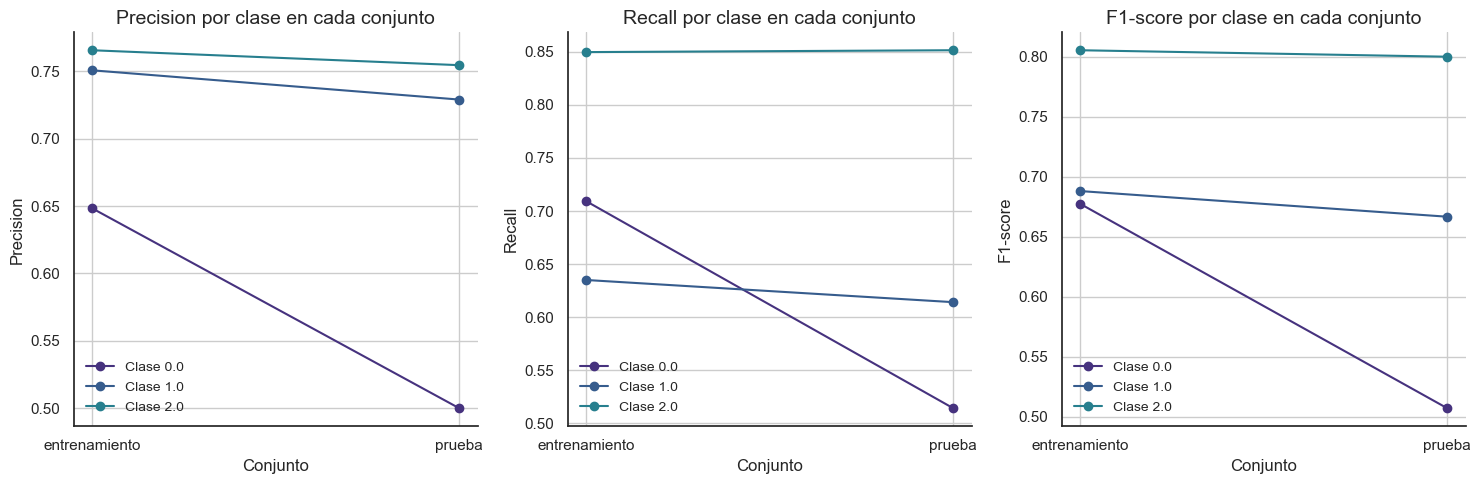

In [36]:
rf_model = rf_grid.best_estimator_
dt_model.fit(X_train, y_train)
y_pred_train_rf, y_pred_test_rf = afn.viz_classification_reports(rf_model, X_train, y_train, X_test, y_test, 'prueba')

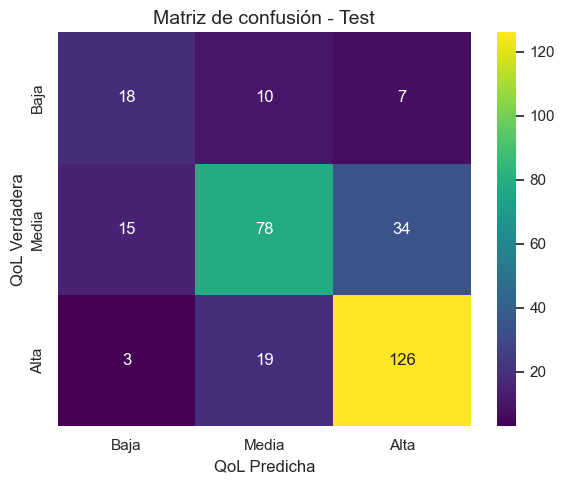

In [37]:
afn.viz_confusion_matrix_test(labels, y_test, y_pred_test_rf)

### 2.3 XGBoost

In [38]:
xg_parameters = {
    'eta': [0.01, 0.03, 0.05],
    'max_depth': [3, 5],
    'min_child_weight': [3, 5, 7],
    'n_estimators': [120, 130, 140],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xg_model = xgb.XGBClassifier(
    objective='multi:softmax',               
    eval_metric='mlogloss',     
    random_state=73,
)

xg_grid = GridSearchCV(
    estimator=xg_model,
    param_grid=xg_parameters,
    scoring='f1_macro',
    cv=5,
    verbose=True,
    n_jobs=-1
)

xg_grid.fit(X_train, y_train)

print('Media de recall: %.3f' % xg_grid.best_score_)
print('Desviación estándar: ', xg_grid.cv_results_['std_test_score'][xg_grid.best_index_].round(3))
print('Parámetros que producen el clasificador óptimo: ')
print('Tasa de aprendizaje: ', xg_grid.best_params_['eta'])
print('Profundidad máxima: ', xg_grid.best_params_['max_depth'])
print('Mínimo peso de división: ', xg_grid.best_params_['min_child_weight'])
print('Número de árboles: ', xg_grid.best_params_['n_estimators'])
print('Subsample: ', xg_grid.best_params_['subsample'])
print('Colsample por árbol: ', xg_grid.best_params_['colsample_bytree'])

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Media de recall: 0.646
Desviación estándar:  0.029
Parámetros que producen el clasificador óptimo: 
Tasa de aprendizaje:  0.05
Profundidad máxima:  5
Mínimo peso de división:  7
Número de árboles:  130
Subsample:  0.8
Colsample por árbol:  0.9


Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.93      0.67      0.78       117
         1.0       0.85      0.82      0.83       422
         2.0       0.84      0.92      0.88       492

    accuracy                           0.85      1031
   macro avg       0.87      0.80      0.83      1031
weighted avg       0.85      0.85      0.85      1031

Reporte sobre el conjunto de prueba:  PRUEBA
              precision    recall  f1-score   support

         0.0       0.52      0.37      0.43        35
         1.0       0.68      0.69      0.68       127
         2.0       0.79      0.82      0.81       148

    accuracy                           0.72       310
   macro avg       0.66      0.63      0.64       310
weighted avg       0.71      0.72      0.71       310



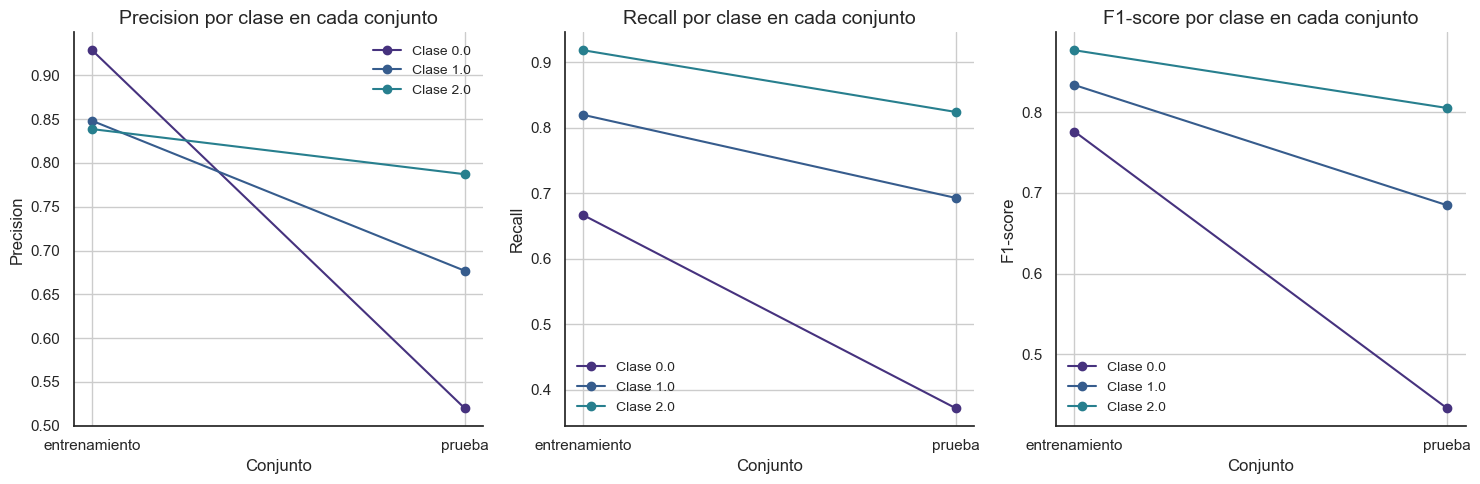

In [39]:
xg_model = xg_grid.best_estimator_
xg_model.fit(X_train, y_train)
y_pred_train_xg, y_pred_test_xg = afn.viz_classification_reports(xg_model, X_train, y_train, X_test, y_test, 'prueba')


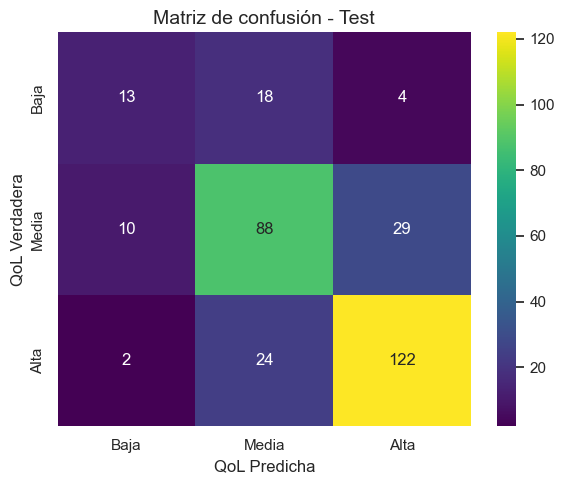

In [40]:
afn.viz_confusion_matrix_test(labels, y_test, y_pred_test_xg)

### Conclusiones